# Research question 1 - Predicting and Classifying number of complaints in Census tracts
#### Abhilash Biswas, Mihir Bhaskar, Jameson Carter
#### 12/08/2021

The following code creates a prediction and classification model where complaints of use of force in Chicago is our outcome variable. 

Exploring what geographical and socio-economic characteristics are associated with complaints of use of force by police is an important policy question to explore. Through the prediction and classification model, we are trying to explore whether we can predict where we would expect to have complaints of use of force. Subject to the robustness and performance of the models, Census tracts where we expect to have higher complaints could become the focus for future policy, trying to understand what drives the police to use force selectively in some geographies. 

Summary:

1. In the first section of the file, I create a prediction model to predict the count of complaints at a Census tract level. As we will see, it is very difficult to predict complaint count and hence our prediction model scores are very low. 

2. Moving on from there, I create a classification model where I classify the binary outcome at a census tract level:
    1 - If there has been atleast 1 use of force complaint in that census tract
    0 - Otherwise

3. The classification model performs much better than the prediction model. However, we are limited in our recall capability for the category 1 (tracts with >0 complaints). 

4. I conclude the code with some brief discussion and analysis. 

For the prediction model, the following steps were followed:
1. Remove some highly correlated predictors that are essentially the mirror of each other (for example, percentage having health insurance and percentage not having health insurance). 
2. Run the model on all predictors. 
3. Tune the model by forward selecting 40 best predictors
4. For the subset of variables, check whether a higher degree regression yeilds better results
5. Conduct a ridge and Lasso shrinkage as well
6. Create and test a Random Forest regression model
7. Compare results of all these tuned models

For the classification model, the following steps were followed:
1. Run a Naive Bayes model on just the 40 predictors
2. Run a Naive Bayes model on all predictors
3. Run a tuned KNN on all predictors
4. Run a logistic regression on all predictors
5. Run a Random Forest classification model
6. Compare results of all these models

#### Import packages

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt
from pyprojroot import here
import seaborn as sns
%matplotlib inline

import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pointbiserialr


import warnings
warnings.filterwarnings('ignore')



#### Import the dataset

In [139]:
data = pd.read_csv(here('./data/Combined.csv'))

### Evaluating the Target Variable- Complaints

In [140]:
data['geometry'] = gpd.GeoSeries.from_wkt(data['geometry'])
GeoData = gpd.GeoDataFrame(data, geometry='geometry')


In [141]:
#Display the dataset
GeoData

,geo_id,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,DP02_0022PE,...,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,inv_stop_count,lakeMI_qmile,river_qmile,Rail_emile,MajorRd_qmile
0,1400000US17031010100,4599.0,23.8,2.5,39.5,34.2,21.5,8.7,1.89,25.4,...,84.0,8.0,3.0,467.0,43.0,3.0,1.0,0.0,1.0,0.0
1,1400000US17031010201,7455.0,33.7,7.2,28.3,30.8,28.2,14.9,2.65,34.5,...,70.0,15.0,0.0,431.0,18.0,18.0,0.0,0.0,1.0,0.0
2,1400000US17031010202,2896.0,23.1,13.6,23.0,40.4,26.9,17.9,2.27,25.1,...,94.0,15.0,2.0,786.0,14.0,16.0,0.0,0.0,1.0,0.0
3,1400000US17031010300,6485.0,25.3,7.4,25.2,42.1,17.0,18.7,1.80,20.0,...,73.0,20.0,4.0,534.0,6.0,9.0,1.0,0.0,0.0,0.0
4,1400000US17031010400,5213.0,17.4,5.7,36.4,40.5,12.5,10.7,1.82,16.8,...,40.0,10.0,2.0,390.0,10.0,39.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,1400000US17031843500,10169.0,33.0,22.8,25.6,18.6,50.9,10.2,3.58,44.1,...,33.0,8.0,0.0,537.0,22.0,40.0,0.0,1.0,1.0,1.0
794,1400000US17031843600,2898.0,12.5,8.8,18.9,59.7,28.4,20.9,2.06,32.5,...,91.0,8.0,0.0,412.0,14.0,35.0,0.0,0.0,0.0,0.0
795,1400000US17031843700,2527.0,51.3,5.6,17.9,25.1,39.6,22.4,2.55,32.6,...,29.0,9.0,2.0,416.0,4.0,77.0,0.0,1.0,0.0,0.0
796,1400000US17031843800,1520.0,19.8,9.5,31.9,38.8,32.4,32.5,2.23,31.1,...,67.0,4.0,3.0,293.0,35.0,41.0,0.0,0.0,1.0,1.0


### Evaluating relationships between variables

The code below creates a correlation matrix for the dataset, and filters it to those variables with the absolute value of correlation greater than 80% (since there are too many variables to visualize in a complete correlation matrix).

In [142]:
# Moving the target variables so they are at the front of the dataset
target = GeoData.pop('complaint_count')
GeoData.insert(loc=0, column='complaint_count', value=target)

# Generating a correlation matrix
# Note: code below sourced from this link: https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
corr = GeoData.corr()

# This code keeps only the upper triangle of the correlation matrix (because the two triangles are copies/repeats)
corr_triu = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))

# This reshapes the matrix to become like a stack, with Var 1, Var 2, and their respective score
corr_triu = corr_triu.stack()

# Making the output more readable
corr_triu.name = 'Correlation Coefficient'
corr_triu.index.names = ['Col1', 'Col2']

# Filtering only those values where absolute value of the correlation is > 80% (i.e. highly correlated variables)
corr_triu = corr_triu[abs(corr_triu) > 0.8].to_frame()

# Ordering from highest correlation to lowest based on absolute correlation
corr_triu.sort_values(by='Correlation Coefficient', key=pd.Series.abs, ascending=False, inplace=True)


#corr_triu.sort_values(by=['Correlation Coefficient'], inplace=True)

print(f'Number of feature pairs that are highly correlated (i.e. >80%): {len(corr_triu)}')

#corr_triu
print(corr_triu)


Number of feature pairs that are highly correlated (i.e. >80%): 57
                                                                   Correlation Coefficient
Col1                             Col2                                                     
ASSAULT                          BATTERY                                          0.963624
DECEPTIVE PRACTICE               THEFT                                            0.953793
ASSAULT                          OTHER OFFENSE                                    0.940364
DP02_0015PE                      DP03_0066PE                                      0.940157
BATTERY                          OTHER OFFENSE                                    0.936715
DP03_0004PE                      DP03_0013PE                                      0.925954
DP05_0037PE                      DP05_0038PE                                     -0.923312
DP02_0093PE                      DP02_0114PE                                      0.917271
BATTERY                

There are several feature pairs, predominantly from the ACS data, that are highly correlated - 28 feature pairs have an absolute correlation coefficient greater than 80%. Some of these variables will need to be dropped based on some other criterion before any modelling efforts.

Some of the other pairs that are highly correlated are:
- % of households with social security and households with a member 65+.
- % of population that is employed and % of women who are employed.
- % of population that is white and % of population that is black.
- % of population born abroad and % of population who do not speak English at home, and who do not speak English 'very well.'

Several of these variables will need to be dropped in the modelling effort through selection methods and cleaning. Some are near-mirrors as they account for similar elements to the same issue. 

## Model training and selection - Prediction

In this section, I create the various prediction models

In [143]:
#Remove any columns with all null values
GeoData = GeoData.dropna(axis=1)
GeoData

,complaint_count,geo_id,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,...,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,inv_stop_count,lakeMI_qmile,river_qmile,Rail_emile,MajorRd_qmile
0,0.0,1400000US17031010100,4599.0,23.8,2.5,39.5,34.2,21.5,8.7,1.89,...,84.0,8.0,3.0,467.0,43.0,3.0,1.0,0.0,1.0,0.0
1,0.0,1400000US17031010201,7455.0,33.7,7.2,28.3,30.8,28.2,14.9,2.65,...,70.0,15.0,0.0,431.0,18.0,18.0,0.0,0.0,1.0,0.0
2,1.0,1400000US17031010202,2896.0,23.1,13.6,23.0,40.4,26.9,17.9,2.27,...,94.0,15.0,2.0,786.0,14.0,16.0,0.0,0.0,1.0,0.0
3,0.0,1400000US17031010300,6485.0,25.3,7.4,25.2,42.1,17.0,18.7,1.80,...,73.0,20.0,4.0,534.0,6.0,9.0,1.0,0.0,0.0,0.0
4,0.0,1400000US17031010400,5213.0,17.4,5.7,36.4,40.5,12.5,10.7,1.82,...,40.0,10.0,2.0,390.0,10.0,39.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,1.0,1400000US17031843500,10169.0,33.0,22.8,25.6,18.6,50.9,10.2,3.58,...,33.0,8.0,0.0,537.0,22.0,40.0,0.0,1.0,1.0,1.0
794,1.0,1400000US17031843600,2898.0,12.5,8.8,18.9,59.7,28.4,20.9,2.06,...,91.0,8.0,0.0,412.0,14.0,35.0,0.0,0.0,0.0,0.0
795,3.0,1400000US17031843700,2527.0,51.3,5.6,17.9,25.1,39.6,22.4,2.55,...,29.0,9.0,2.0,416.0,4.0,77.0,0.0,1.0,0.0,0.0
796,1.0,1400000US17031843800,1520.0,19.8,9.5,31.9,38.8,32.4,32.5,2.23,...,67.0,4.0,3.0,293.0,35.0,41.0,0.0,0.0,1.0,1.0


### Running a kitchen sink model with all variables

In [144]:
#Creating X and y dataframes
df_y = GeoData['complaint_count']

# Remove target variable, perfectly correlated variables and some other highly correlated vars mentioned above
df_X = GeoData.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 

df_X = df_X.select_dtypes(['number']) 

#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(df_X,df_y,test_size = 0.20, random_state = 5)                                                      
                                                                                        
#Fitting model
lm_r1 = LinearRegression()
lm_r1.fit(X_train, y_train)

#Calculating MSE
MSE_train  = mean_squared_error(y_train, lm_r1.predict(X_train))
print("Training R-squared: ", lm_r1.score(X_train, y_train))
print("MSE train: " , MSE_train)

MSE_test  = mean_squared_error(y_test, lm_r1.predict(X_test))
print("Testing R-squared: ", lm_r1.score(X_test, y_test))
print("MSE test: " , MSE_test)

Training R-squared:  0.4884174182174471
MSE train:  0.9476752995892527
Testing R-squared:  0.18461828514088163
MSE test:  1.7489619275245722


We have a likely overfitted model based on the difference in training and testing R squared. This also means that our values for R squared may fluctuate a lot depending on how the dataset is being splitted randomly. 

### Model Tuning and validation

In this section, we apply various methodologies to tune this model and check how much this model can be improved. 

In [145]:
#First splitting the entire dataset into model building and validation set
df_validation = GeoData.sample(frac = 0.2, random_state = 1)

df_model = GeoData.drop(df_validation.index)

#Instead of using the normal X train and y train method of splitting, I use this method to better keep track of all the 
# datasets around since we would be using the full dataset in some models and the trimmed one in others

In [146]:
df_validation

,complaint_count,geo_id,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,...,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,inv_stop_count,lakeMI_qmile,river_qmile,Rail_emile,MajorRd_qmile
8,4.0,1400000US17031010600,6395.0,28.6,11.4,26.3,33.8,14.2,11.3,2.12,...,72.0,8.0,1.0,473.0,16.0,39.0,1.0,0.0,0.0,0.0
509,3.0,1400000US17031530501,4148.0,22.5,2.2,25.4,49.9,22.4,42.8,2.78,...,130.0,16.0,2.0,381.0,150.0,31.0,0.0,0.0,1.0,0.0
175,0.0,1400000US17031140702,5882.0,33.7,12.4,29.2,24.7,36.5,13.6,2.93,...,80.0,10.0,0.0,344.0,37.0,32.0,0.0,0.0,0.0,0.0
366,0.0,1400000US17031300600,3035.0,39.9,13.3,12.5,34.4,55.7,20.7,3.77,...,48.0,10.0,1.0,154.0,18.0,46.0,0.0,0.0,1.0,0.0
242,1.0,1400000US17031210601,2841.0,43.3,5.4,17.8,33.5,21.8,21.3,2.88,...,43.0,7.0,0.0,200.0,10.0,51.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,0.0,1400000US17031283800,3668.0,29.4,4.7,23.4,42.5,24.1,13.8,2.23,...,22.0,5.0,0.0,245.0,6.0,39.0,0.0,0.0,1.0,0.0
663,0.0,1400000US17031730201,5262.0,16.9,4.9,27.6,50.6,24.9,36.4,2.33,...,152.0,13.0,3.0,769.0,60.0,17.0,0.0,0.0,1.0,0.0
712,1.0,1400000US17031833100,7436.0,32.6,9.2,22.0,36.2,16.5,8.9,1.82,...,101.0,8.0,3.0,1515.0,3.0,27.0,0.0,0.0,0.0,1.0
594,2.0,1400000US17031661000,5434.0,25.2,4.6,22.3,47.9,32.0,35.5,2.86,...,137.0,8.0,1.0,643.0,89.0,38.0,0.0,0.0,1.0,0.0


In [147]:
#Creating train and test sets for the modelling dataset
df_model_y = df_model['complaint_count']

# Remove target variable, perfectly correlated variables and some other highly correlated vars mentioned above
df_model_X = df_model.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 



In [148]:
#Now selecting 40 best predictors using forward stepwise
model= LinearRegression()
sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = 40, 
                                    direction="forward",
                                    scoring='neg_mean_squared_error',
                                    cv= 10) 

sfs = sfs.fit(df_model_X,df_model_y)
feature_names = np.array(df_model_X.columns)
print("# of features : ",40)
print("Features selected by forward sequential selection: "+str(feature_names[sfs.get_support()]))

predictor_subset = list((feature_names[sfs.get_support()]))
df_subset = df_model_X[predictor_subset]
    
score = np.mean(cross_val_score(model,df_subset, df_model_y, scoring='neg_mean_squared_error', cv = 10))
print("CV score: ", score)



# of features :  40
Features selected by forward sequential selection: ['DP02_0010PE' 'DP02_0026PE' 'DP02_0037PE' 'DP02_0044PE' 'DP02_0053PE'
 'DP02_0054PE' 'DP02_0074PE' 'DP02_0085PE' 'DP02_0114PE' 'DP02_0153PE'
 'DP03_0029PE' 'DP03_0030PE' 'DP03_0031PE' 'DP03_0048PE' 'DP03_0119PE'
 'DP04_0003PE' 'DP04_0065PE' 'DP04_0069PE' 'DP04_0073PE' 'DP04_0136PE'
 'DP05_0044PE' 'police_stations' 'fire_stations'
 'commercial_establishments' 'number_of_police_killings' 'ARSON' 'ASSAULT'
 'CRIMINAL SEXUAL ASSAULT' 'INTERFERENCE WITH PUBLIC OFFICER'
 'INTIMIDATION' 'NON - CRIMINAL' 'NON-CRIMINAL'
 'OFFENSE INVOLVING CHILDREN' 'OTHER OFFENSE' 'PUBLIC INDECENCY'
 'PUBLIC PEACE VIOLATION' 'ROBBERY' 'STALKING' 'WEAPONS VIOLATION'
 'Rail_emile']
CV score:  -1.3678466158263498


We see that we have a bunch of socio-economic variables, variables representing crime and one displaying the proximity of railway lines to census tracts as our best set of 40 variables

I also ran this model to check the following number of predictors and got the following values:
10 - 1.45
20 - 1.37
30 - 1.369
40 - 1.367
60 - 1.62

In [149]:
#Now creating trimmed datasets to only contain these predictors

#Validation set
df_validation_y = df_validation['complaint_count']

df_validation_X = df_validation.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 

df_validation_X_trim = df_validation_X[predictor_subset]

#Modelling set
df_model_X_trim = df_model_X[predictor_subset]

In [150]:
df_validation_X_trim

,DP02_0010PE,DP02_0026PE,DP02_0037PE,DP02_0044PE,DP02_0053PE,DP02_0054PE,DP02_0074PE,DP02_0085PE,DP02_0114PE,DP02_0153PE,...,NON - CRIMINAL,NON-CRIMINAL,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,STALKING,WEAPONS VIOLATION,Rail_emile
8,33.8,58.8,28.0,0.0,1730.0,7.3,5.3,2.6,17.0,83.0,...,0.0,0.0,10.0,116.0,0.0,10.0,72.0,1.0,16.0,0.0
509,49.9,57.0,79.0,202.0,827.0,3.0,3.8,0.0,0.6,76.8,...,0.0,0.0,39.0,336.0,0.0,25.0,130.0,2.0,150.0,1.0
175,24.7,51.7,88.0,109.0,1514.0,2.8,4.2,1.2,30.3,72.3,...,0.0,0.0,15.0,82.0,1.0,17.0,80.0,0.0,37.0,0.0
366,34.4,55.5,23.0,100.0,907.0,4.2,1.9,0.9,28.5,73.9,...,0.0,0.0,13.0,79.0,0.0,15.0,48.0,1.0,18.0,1.0
242,33.5,48.4,0.0,47.0,756.0,3.2,1.1,1.1,25.6,87.8,...,0.0,0.0,2.0,33.0,0.0,3.0,43.0,0.0,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,42.5,41.9,117.0,34.0,789.0,5.7,0.0,4.1,5.6,74.6,...,0.0,1.0,15.0,94.0,0.0,2.0,22.0,0.0,6.0,1.0
663,50.6,56.8,59.0,400.0,1049.0,6.1,0.0,0.9,0.0,64.7,...,0.0,0.0,38.0,293.0,0.0,13.0,152.0,3.0,60.0,1.0
712,36.2,50.1,182.0,57.0,1150.0,7.0,1.6,4.9,1.9,90.6,...,0.0,0.0,9.0,193.0,0.0,25.0,101.0,3.0,3.0,0.0
594,47.9,58.7,53.0,226.0,1442.0,6.2,6.6,0.8,5.0,71.4,...,0.0,1.0,24.0,318.0,0.0,20.0,137.0,1.0,89.0,1.0


In [151]:
#Now finding the best polynomial model
for i in range(1,4):
    poly_model = PolynomialFeatures(degree = i)
    
    X_poly_train = poly_model.fit_transform(df_model_X_trim)

    lm_poly = LinearRegression()
    lm_poly.fit(X_poly_train, df_model_y)
    
    CV_score = np.mean(cross_val_score(lm_poly,X_poly_train,df_model_y,cv = 10, scoring = 'neg_mean_squared_error'))
    
    print("Degree: ",i)
    print("Avg CV score: ",CV_score)


Degree:  1
Avg CV score:  -1.3678330043725926
Degree:  2
Avg CV score:  -302.35974862836076
Degree:  3
Avg CV score:  -15109.015419714855


We can see that a linear regression would be the best one to go with in this case. 

### Applying shrinkage methods

Since shrinkage methods are another way of reducing variables, in this sub-section I apply the Ridge and Lasso shrinkage on the full set of predictors. 

In [152]:
#Checking if a ridgeCV model works better
#Setting a range of alphas
alphas = np.logspace(-5, 5, 100)

#Fitting model
model_ridgeCV = RidgeCV(cv=10, alphas = alphas, scoring = "neg_mean_squared_error").fit(df_model_X, df_model_y)

#Printing scores
print("Ridge regression")
print("Ridge - best_score: \n",model_ridgeCV.best_score_)
print("Ridge - best alpha: "+str(model_ridgeCV.alpha_))


#To compare with a plain linear model
linear_model = LinearRegression()
linear_model.fit(df_model_X,df_model_y)
score = np.mean(cross_val_score(linear_model,df_model_X_trim,df_model_y, scoring = 'neg_mean_squared_error',cv = 10))
print("linear model CV score :", score)

Ridge regression
Ridge - best_score: 
 -1.6480388261866576
Ridge - best alpha: 100000.0
linear model CV score : -1.3678466158263498


In [153]:
#Creating a ridge model with the recommended alpha
model_ridge = Ridge()
model_ridge.set_params(alpha=model_ridgeCV.alpha_)
model_ridge.fit(df_model_X,df_model_y)





Ridge(alpha=100000.0)

In [154]:
#Doing the same as above for Lasso
model_lassoCV = LassoCV(cv=10).fit(df_model_X,df_model_y)

print("Lasso - R-squared: "+str(model_lassoCV.score(df_model_X,df_model_y)))
print("Lasso - best alpha: "+str(model_lassoCV.alpha_))


Lasso - R-squared: 0.26382098757863315
Lasso - best alpha: 10.239041174909843


In [155]:
#Fitting a Lasso model with the recommended alpha
model_lasso = Lasso()
model_lasso.set_params(alpha=model_lassoCV.alpha_)
model_lasso.fit(df_model_X,df_model_y)



Lasso(alpha=10.239041174909843)

In [156]:
#Now let's check how well these models perform against the validation set
linear_model = LinearRegression().fit(df_model_X_trim,df_model_y)

linear_model_score = linear_model.score(df_validation_X_trim,df_validation_y)
MSE_test  = mean_squared_error(df_validation_y, linear_model.predict(df_validation_X_trim))


print("OLS")
print("R squared: ", linear_model_score)
print("MSE test : ", MSE_test)


#Checking the same for Ridge model
print("Ridge")
ridge_model_score = model_ridge.score(df_validation_X,df_validation_y)
print("R squared: ", ridge_model_score)

#Checking for Lasso model
print("Lasso")
lasso_model_score = model_lasso.score(df_validation_X,df_validation_y)
print("R squared: ", lasso_model_score)

OLS
R squared:  -0.0013572105927623923
MSE test :  1.0013180950767235
Ridge
R squared:  0.1248969791398048
Lasso
R squared:  0.1858518934625114


We see that the normal OLS model is not able to predict anything as the R squared is essentially 0. While the Ridge and Lasso models are slightly better, in an absolute sense, their performance is also quite low. The Ridge model is only able to explain 12% of the variation in use of force complaints and the Lasso model is able to explain 18.5% of the same variation

### Running a random forest regressor

Since prediction models have been performing bad in general, I just try out different n_estimators rather than doing a full gridsearch CV. 

In [157]:
#Trying a Random Forest Regressor and checking performance against validation test

for i in [100,200,300,400,500]:
    
    rd = RandomForestRegressor(n_estimators = i, max_depth = 30, random_state = 1)
    rd.fit(df_model_X,df_model_y)

    y_pred=rd.predict(df_validation_X)

    train_score = rd.score(df_model_X,df_model_y)
    test_score = rd.score(df_validation_X,df_validation_y)
    
    print("n_estimators = ",i)
    print("Train r sqaured", train_score)
    print("Test r sqaured", test_score)



n_estimators =  100
Train r sqaured 0.8849145162320231
Test r sqaured 0.1599412824285671
n_estimators =  200
Train r sqaured 0.8878325854843299
Test r sqaured 0.19235952793294886
n_estimators =  300
Train r sqaured 0.8891842534627061
Test r sqaured 0.18820726311164748
n_estimators =  400
Train r sqaured 0.8923019129077545
Test r sqaured 0.1824476303327821
n_estimators =  500
Train r sqaured 0.8930629057239522
Test r sqaured 0.18342832489116323


In various iterations for the RF regressor, the best test R squared we are able to get is 19%. This suggests that even the Random Forest model is not being able to make accurate predictions

### Conclusions from prediction section

The biggest takeaway from this section is that it is very difficult to predict the exact use of force complaint count at a census tract level. There could be various reasons behind this. Some of those are discussed in the discussion section at the end of this code file. It is also important to note that even after all the tuning, the model isn't performing any better than a kitchen sink model (run at the beginning)

However, one reason worth mentioning here is that it may be difficult to predict an exact count of complaints (which we are trying to do above). Hence, it is worth exploring if instead of exact complaint count, can we predict whether a tract would have a complaint or not (as a binary outcome). In the next section, we explore this question through a classification exercise. 


## Model training, selection and performance - Classification

We will classify complaint rate into Any complaints (1) and no complaints (0). It appears that there are 454 tracts without complaints of use-of-force and 344 with complaints of use-of-force. This seems decently well-balanced.

In [158]:
#Creating datasets

#Model building set
df_c_model_y = pd.DataFrame(df_model_y)
df_c_model_y['any_complaints'] = np.where(df_c_model_y['complaint_count']>0, 1, 0)
df_c_model_y = df_c_model_y['any_complaints']

#Validation set
df_c_validation_y = pd.DataFrame(df_validation_y)
df_c_validation_y['any_complaints'] = np.where(df_c_validation_y['complaint_count']>0, 1, 0)
df_c_validation_y = df_c_validation_y['any_complaints']
df_c_validation_y




8      1
509    1
175    0
366    0
242    1
      ..
358    0
663    0
712    1
594    1
108    0
Name: any_complaints, Length: 160, dtype: int64

### Naive Bayes

              precision    recall  f1-score   support

           0      0.667     0.844     0.745        90
           1      0.696     0.457     0.552        70

    accuracy                          0.675       160
   macro avg      0.681     0.651     0.648       160
weighted avg      0.679     0.675     0.660       160



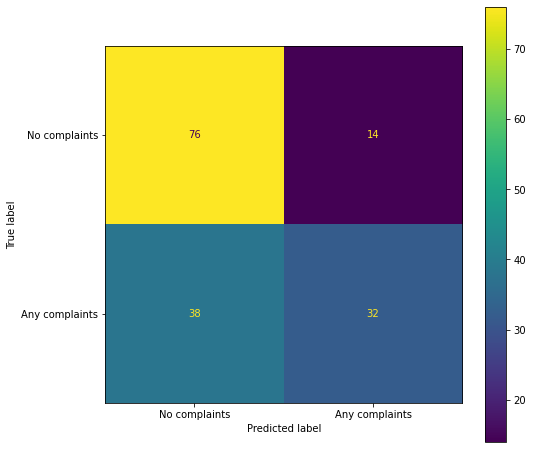

In [159]:
#Creating a Naive Bayes model (using the best subset predictors)

#Defining model
model_nb = GaussianNB()
nb_pred = model_nb.fit(df_model_X_trim, df_c_model_y).predict(df_validation_X_trim) 
print(classification_report(df_c_validation_y,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(df_c_validation_y,nb_pred) 
target_names = ['No complaints','Any complaints']

display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
fig, ax = plt.subplots(figsize=(8,8))
display_cm.plot(ax=ax)


              precision    recall  f1-score   support

           0      0.653     0.856     0.740        90
           1      0.690     0.414     0.518        70

    accuracy                          0.662       160
   macro avg      0.672     0.635     0.629       160
weighted avg      0.669     0.662     0.643       160



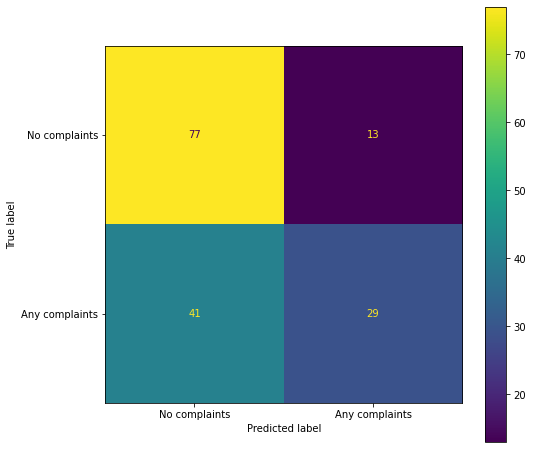

In [160]:
#Creating a Naive Bayes model (using all predictors)

#Defining model
model_nb = GaussianNB()
nb_pred = model_nb.fit(df_model_X,df_c_model_y).predict(df_validation_X) 
print(classification_report(df_c_validation_y,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(df_c_validation_y,nb_pred) 
target_names = ['No complaints','Any complaints']

display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
fig, ax = plt.subplots(figsize=(8,8))
display_cm.plot(ax=ax)

                                                                                        


We get quite an average accuracy of 66.2%. While the recall is high for category 0 (No complaints) at 85.6%, it is quite low for the category 1 (any complaints) at 41.4%. 

When we classify using only the best 40 predictors, we have a minor improvement in our model. 

### KNN

best k:  9
              precision    recall  f1-score   support

           0      0.609     0.778     0.683        90
           1      0.556     0.357     0.435        70

    accuracy                          0.594       160
   macro avg      0.582     0.567     0.559       160
weighted avg      0.585     0.594     0.574       160



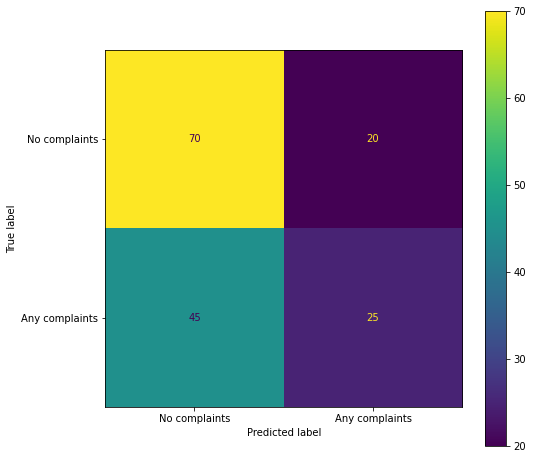

In [161]:
#Creating a KNN model
#Since KNN get's affected by irrelevant variables, we will run the model only on the best 40 predictors

#Tuning the model to get best k
#Calculating CV scores based on accuracy (for k = 1,10)
neighbours = []
accuracy_score = []

#Iterating through different values of # of neighbours (not splitting into train and test as we are doing CV)
for k in range(1,10):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(df_model_X_trim,df_model_y)
    
    scores = cross_val_score(knn, df_model_X_trim,df_model_y,cv=5, scoring = 'accuracy')
    mean_score = scores.mean()
    
    neighbours.append(k)
    accuracy_score.append(mean_score)

#Finding optimum K
index_max_accuracy = accuracy_score.index(max(accuracy_score))
best_k = neighbours[index_max_accuracy]
print("best k: ",best_k)

knn = KNeighborsClassifier(n_neighbors = best_k)  
knn.fit(df_model_X_trim,df_c_model_y)

#Predicting test values
y_pred = knn.predict(df_validation_X_trim)
y_pred

#Confusion matrix
cm = confusion_matrix(df_c_validation_y,y_pred)
target_names = ['No complaints','Any complaints']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
fig, ax = plt.subplots(figsize=(8,8))
display_cm.plot(ax=ax)

#Classification report
print(classification_report(df_c_validation_y,y_pred,digits = 3))


We see that the KNN model performs worse than the Naive Bayes model

### Logistic Regression

              precision    recall  f1-score   support

           0      0.664     0.789     0.721        90
           1      0.642     0.486     0.553        70

    accuracy                          0.656       160
   macro avg      0.653     0.637     0.637       160
weighted avg      0.654     0.656     0.647       160



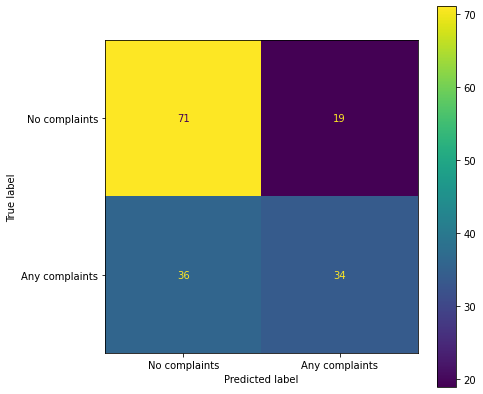

In [162]:
#Creatinng a logistic regression model on all predictors
model_lg = LogisticRegression()

model_pred = model_lg.fit(df_model_X,df_c_model_y).predict(df_validation_X) 
cm = confusion_matrix(df_c_validation_y,model_pred) 

display_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=['No complaints','Any complaints'])
fig, ax = plt.subplots(figsize=(7,7))
display_cm.plot(ax=ax)
print(classification_report(df_c_validation_y, model_pred, digits=3))

We see that a logistic regression performs similar to the Naive Bayes model, but it has a lower recall for category 0 and slightly higher recall for category 1 as compared to the Naive Bayes model. 

### Random Forest

In [163]:
#Performing GridSearch to tune a Random Forest model

n_estimators_range = [300,400,500]
max_depth_range = [30,40]
min_sample_split_range = [2,6]
params = {'n_estimators':n_estimators_range,
          'max_depth':max_depth_range,
          'min_samples_split':min_sample_split_range,
          'criterion' :['gini', 'entropy']}

#Running the gridsearchCV
estimator = RandomForestClassifier(random_state = 1)
gs_rf = GridSearchCV(estimator,param_grid = params, cv = 5, n_jobs = -1)
gs_rf.fit(df_model_X,df_c_model_y)

gs_rf.best_params_



{'criterion': 'gini',
 'max_depth': 30,
 'min_samples_split': 6,
 'n_estimators': 400}

              precision    recall  f1-score   support

           0      0.733     0.733     0.733        90
           1      0.657     0.657     0.657        70

    accuracy                          0.700       160
   macro avg      0.695     0.695     0.695       160
weighted avg      0.700     0.700     0.700       160



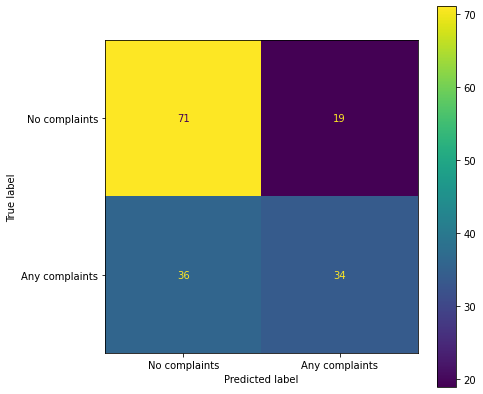

In [164]:
#Conducting Random forest classification model

clf_rf = RandomForestClassifier(n_estimators = 400, max_depth = 30, min_samples_split = 6, 
                                 random_state = 1)

clf_rf.fit(df_model_X,df_c_model_y)

y_pred_rf = clf_rf.predict(df_validation_X)

print(classification_report(df_c_validation_y,y_pred_rf,digits = 3))

cm = confusion_matrix(df_c_validation_y,y_pred_rf) 

dissplay_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=['No complaints','Any complaints'])
fig, ax = plt.subplots(figsize=(7,7))
display_cm.plot(ax=ax)


We see that while the accuracy of this model is similar to others, the recall for category 1 has improved quite a bit as compared to other models

<BarContainer object of 10 artists>

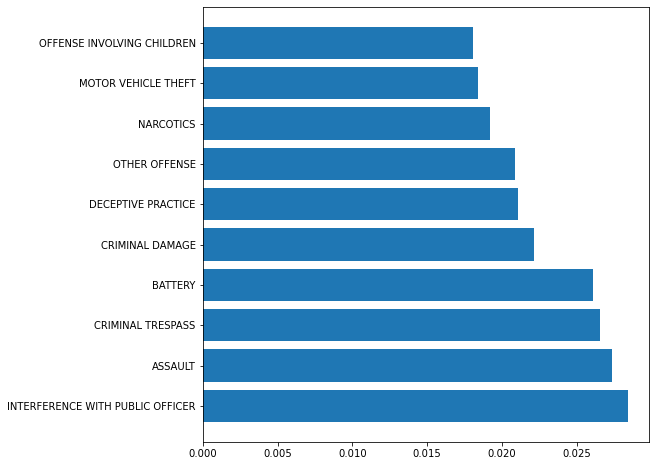

In [165]:
#Checking most important vars 

#create dataframe
feature_imp = clf_rf.feature_importances_
feature_array = np.array(df_model_X.columns)

df = pd.DataFrame({'Feature names': feature_array, 'Feature importance': feature_imp})
df.sort_values('Feature importance',ascending = False, inplace=True)

#Keeping top 10 features
df_short = df.head(10)

#create plot
plt.figure(figsize = (8,8))
plt.barh(df_short['Feature names'], df_short['Feature importance'])

It is interesting to note that number of violations of interferencce with a public officer in a census tract is the most important variable to predict whether a tract would have a use of force complaint or not. 



## Model performance (a comparison)

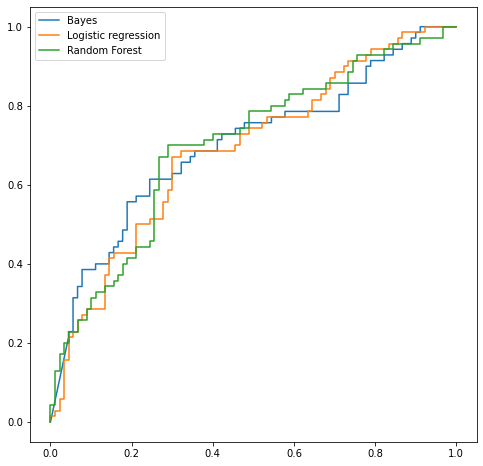

In [166]:
#Plotting ROC AUC curve

#Naive Bayes
nb_probs = model_nb.predict_proba(df_validation_X)
auc_bayes = roc_auc_score(df_c_validation_y, nb_probs[:,1])
nb_fpr, nb_tpr, thresholds = roc_curve(df_c_validation_y, nb_probs[:,1])

#Logistic regression
lg_probs = model_lg.predict_proba(df_validation_X)
auc_log = roc_auc_score(df_c_validation_y, lg_probs[:,1])
lg_fpr, lg_tpr, thresholds = roc_curve(df_c_validation_y, lg_probs[:,1])

#Random forest
rf_probs = clf_rf.predict_proba(df_validation_X)
auc_rf = roc_auc_score(df_c_validation_y, rf_probs[:,1])
rf_fpr, rf_tpr, thresholds = roc_curve(df_c_validation_y, rf_probs[:,1])


#Plot
plt.figure(figsize = (8,8))
plt.plot(nb_fpr,nb_tpr, label = "Bayes")
plt.plot(lg_fpr,lg_tpr, label = "Logistic regression")
plt.plot(rf_fpr,rf_tpr, label = "Random Forest")
plt.legend()

plt.show()

In [167]:
print("auc Naive Bayes: ",auc_bayes)
print("auc Logistic: ", auc_log)
print("auc Random Forest: ",auc_rf)

auc Naive Bayes:  0.7007936507936509
auc Logistic:  0.6882539682539682
auc Random Forest:  0.7


In [168]:
#Seeing how well correlated our outcome variable is with top 5 important variables

GeoData['any_complaints'] = np.where(GeoData['complaint_count']>0, 1, 0)

#Running point biserial correlation since outcome variable is binary

correlation_1 = pointbiserialr(GeoData['any_complaints'], GeoData['INTERFERENCE WITH PUBLIC OFFICER'])[0]

#Human trafficking
correlation_2 = pointbiserialr(GeoData['any_complaints'], GeoData['ASSAULT'])[0]

#Percentage of households having wood based heating
correlation_3= pointbiserialr(GeoData['any_complaints'], GeoData['CRIMINAL TRESPASS'])[0]

#Census tract having a Major road in it's vicinity
correlation_4 = pointbiserialr(GeoData['any_complaints'], GeoData['BATTERY'])[0]


#Printing correlations
print("Correlation between any complaints and interference with public officer: ", round(correlation_1,2))
print("Correlation between any complaints and Assaults: ", round(correlation_2,2))
print("Correlation between any complaints and Criminal trespass: ", round(correlation_3,2))
print("Correlation between any complaints and Battery crime violations: ", round(correlation_4,2))




Correlation between any complaints and interference with public officer:  0.34
Correlation between any complaints and Assaults:  0.38
Correlation between any complaints and Criminal trespass:  0.28
Correlation between any complaints and Battery crime violations:  0.39


### Conclusion from classification section

We see that our best classification models are Naive Bayes and Random Forest. However, one key takeaway is that all models except KNN perform very similar to each other. 

Overall, we are able to classify with an accuracy of about 70%. We are more precise and also have better recall in categories where the any_complaints = 0 as compared to the category where any_complaints = 1

## Discussion

We see that we are able to classify whether a tract has had any use of force complaint much better than we are able to predict the exact count of use of force complaints. This makes sense as predicting the exact count of complaints is more difficult than predicting whether a tract would have 0 or atleast 1 complaint. Even within classification, we have a modest accuracy of about 70% and we perform worse on classifying tracts that have had atleast 1 complaint as compared to tracts that have had no complaints. 

We see that count of violations of interference with public officer in a tract is an important variable for classification. While this makes sense, it could also be a causal factor for a use of force complaint. However, one of the key learnings is that even our top 4 important variables have quite a low correlation with the outcome variable. Hence, it is a limitation of our models. 

It is important to note that we are trying to use use of force complaints as a proxy for police violence and there may be several limitations to it. For example, people in tracts where police uses violence more may also have a greater distrust in the system and hence file less complaints. 

Additionally, use of force must be highly correlated with problematic police offficers. While we have quite an exhaustive set of demographic and geographic variables, we do not have any information on where the problematic officers are located or which beats do they patrol. 

## Future work


There are several limitations in the above model which can be improved upon. 

1. Collecting more data on indicators related to police officers/precints governing a census tract

As mentioned above, our model only uses socio-economic and geographic indicators to predict use of force complaints. However, it is quite likely that the characteristics of a police precinct governing a census tract would also have a large impact on the number of use of force complaints coming from that tract. Hence in future, these models can be made more robust be adding predictors on police characteristics. 

2. Obtaining data on direct use of force incidents

We have been using the complaints of use of force as a proxy for actual use of force incidents. In future, depending on availability of data, it would make the models more robust to include actual use of force incidents as complaints can have bias. 

3. Assessing other metrics of police violence

The big picture goal of this exercise is to model what conditions and characteristics are associated with police violence on citizens. Unnecessary use of force is one metric to measure this. In the future, we could model other metrics of police violence (such as civilians injured by police, other categories of complaints apart from use of force, civilian deaths or an indexed combination of these outcomes) using similar predictors. 


## Sources

 - https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
 - https://stackoverflow.com/questions/38372188/how-to-add-k-means-predicted-clusters-in-a-column-to-a-dataframe-in-python
 - https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
 - https://stackoverflow.com/questions/33575587/pandas-dataframe-how-to-apply-describe-to-each-group-and-add-to-new-columns
 - In class labs and homeworks on prediction and classification
 - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html